In [1]:
using PyPlot

Let's look at using stochastic gradient descent with various methods to optimize logistic regression.
First, we'll generate a training set at random from the generative model associated with logistic regression.
This generative model is, for label $y \in \{-1,1\}$, features $x \in \mathbb{R}^d$ and model $w \in \mathbb{R}^d$,

$$\mathbf{P}_w(y | x) = \frac{1}{1 + \exp(-y x^T w)}.$$

This means that if we make a bunch of independent observations, the total probability is

$$p(w) = \prod_{i=1}^N \frac{1}{1 + \exp(-y_i x_i^T w)}$$

and so maximizing this is equivalent to maximizing the log likelihood

$$\log p(w) = -\sum_{i=1}^N \log \left( 1 + \exp(-y_i x_i^T w) \right).$$

The gradient of this is

$$\nabla \log p(w) = -\sum_{i=1}^N \frac{\exp(-y_i x_i^T w) \cdot (-y_i x_i)}{1 + \exp(-y_i x_i^T w)}$$

which reduces to

$$\nabla \log p(w) = \sum_{i=1}^N \frac{y_i x_i}{1 + \exp(y_i x_i^T w)}.$$

Anyway, we can see that this corresponds to logistic regression.

In [2]:
# generate the data
srand(424242)
d = 20;
N = 10000;
wtrue = randn(d);
wtrue = d^2 * wtrue / norm(wtrue);
X = randn(N, d);
X ./= sqrt(sum(X.^2, 2));
Y = (1 ./ (1 + exp(-X * wtrue)) .>= rand(N)) * 2 - 1;
sigma = 0.001;

Let's do logistic regression with regularization here. Our objective samples will be of the form

$$f_i(w) = -\log \left( 1 + \exp(-y_i x_i^T w) \right) + \frac{\sigma}{2} \| w \|^2$$

and the SGD updates will look like

$$w_{t+1} = w_t + \alpha_t \left( \frac{y_i x_i}{1 + \exp(y_i x_i^T w_t)} - \sigma w_t \right)$$.

Let's look at the constants of strong convexity and Lipschitz continuity for this problem, to get a handle on the theory/optimal parameters. If we differentiate the objective twice, we get

$$\nabla^2 f_i(w) = x_i x_i^T \frac{1}{(1 + \exp(y_i x_i^T w_t)) (1 + \exp(-y_i x_i^T w_t))} + \sigma I.$$

It's pretty easy to see that

$$0 < \frac{1}{(1 + \exp(u)) (1 + \exp(-u))} \le \frac{1}{4},$$

and so since we initialized such that $\| x_i \|^2 = 1$, from the way we generated the examples, we can approximate 

$$\sigma I \preceq \nabla^2 f_i(w) \preceq \left(\sigma + \frac{1}{4} \right) I.$$

So we can set $\mu = \sigma$ and $L = \sigma + \frac{1}{4}$.
What about bounding the variance of the gradient samples?  (Again here I'm using the nonstandard definition of variance for vectors: $\mathbf{Var}(X) = \mathbf{E}[\| X \|^2] - \| \mathbf{E}[ X ] \|^2$.)
Well,

\begin{align*}
    \mathbf{Var}(\nabla f_i(w))
    &=
    \mathbf{Var}\left( \frac{y_i x_i}{1 + \exp(y_i x_i^T w)} - \sigma w \right) \\
    &=
    \mathbf{Var}\left( \frac{y_i x_i}{1 + \exp(y_i x_i^T w)} \right) \\
    &\le
    \mathbf{E}\left[ \left\| \frac{y_i x_i}{1 + \exp(y_i x_i^T w)} \right\|^2 \right] \\
    &\le
    \mathbf{E}\left[ \left\| x_i \right\|^2 \right] \\
    &\le
    1
\end{align*}

where this last line happens because we sampled $x_i$ uniformly from the unit ball. So we can set $M = 1$.

In [3]:
mu = sigma;
L = sigma + 0.25;
M = 1;

What is the optimal step size for SGD under these conditions?
Well, from Lecture 2, we had
$$\alpha_t = \frac{2 \mu \| w_0 - w^* \|^2}{4 M + \mu^2 \| w_0 - w^* \|^2 t}$$
or
$$\alpha_t = \frac{\alpha_0}{1 + \gamma t}$$
where
$$\alpha_0 = \frac{2 \mu \| w_0 - w^* \|^2}{4 M}$$
and
$$\gamma = \frac{\mu^2 \| w_0 - w^* \|^2}{4 M}.$$

In [4]:
w0 = randn(d);

In [5]:
function sgd_logreg(w0, alpha0, gamma, X, Y, sigma, niters, wopt)
    w = w0
    (N, d) = size(X)
    dist_to_optimum = zeros(niters)
    for k = 1:niters
        alpha = alpha0 / (1 + gamma * (k-1));
        i = rand(1:N)
        xi = X[i,:];
        yi = Y[i];
        w = (1 - alpha * sigma) * w + alpha * xi * yi / (1 + exp(yi * dot(xi, w)));
        dist_to_optimum[k] = norm(w - wopt);
    end
    return (w, dist_to_optimum);
end

sgd_logreg (generic function with 1 method)

In [6]:
# find the true minimum
function newton_logreg(w0, X, Y, sigma, niters)
    N = size(X, 1);
    d = size(X, 2);
    w = w0;
    for k = 1:niters
        g = -X' * (Y ./ (1 + exp(Y .* (X * w)))) + N * sigma * w;
        H = X' * ((1 ./ ((1 + exp(Y .* (X * w))) .* (1 + exp(-Y .* (X * w))))) .* X) + N * sigma * eye(d);
        w = w - H \ g;
        println("gradient norm: $(norm(g))")
    end
    return w
end

newton_logreg (generic function with 1 method)

In [7]:
wopt = newton_logreg(wtrue, X, Y, sigma, 10);

gradient norm: 3999.9774577369785
gradient norm: 896.3972587628689
gradient norm: 233.89715512117843
gradient norm: 59.370770718984
gradient norm: 5.959623034633453
gradient norm: 0.06910877657919792
gradient norm: 9.433183413409561e-6
gradient norm: 2.777799306773163e-13
gradient norm: 6.563211845551944e-14
gradient norm: 4.618954771558417e-14


In [8]:
alpha0 = 2 * mu * norm(w0 - wopt)^2 / (4 * M);
gamma = mu^2 * norm(w0 - wopt)^2 / (4 * M);

In [9]:
srand(123456);
(w, dto) = sgd_logreg(w0, alpha0, gamma, X, Y, sigma, 50000, wopt);

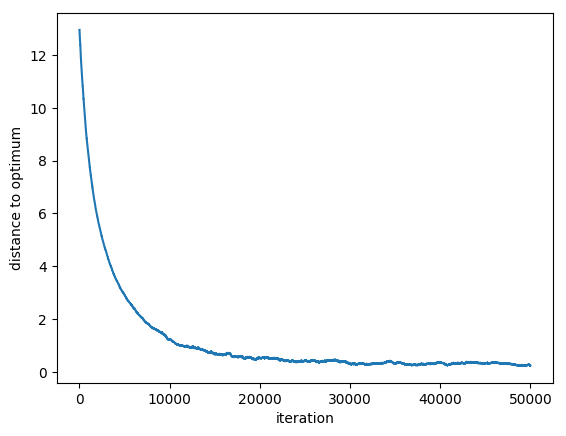

In [10]:
plot(dto)
xlabel("iteration");
ylabel("distance to optimum");

In [11]:
srand(123456);
(w2, dto2) = sgd_logreg(w0, 2*alpha0, 4*gamma, X, Y, sigma, 50000, wopt);
srand(123456);
(w2, dto3) = sgd_logreg(w0, 3*alpha0, 9*gamma, X, Y, sigma, 50000, wopt);

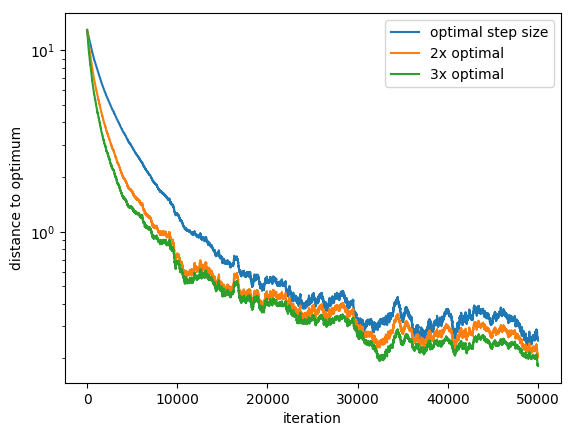

In [12]:
semilogy(dto; label = "optimal step size")
semilogy(dto2; label = "2x optimal")
semilogy(dto3; label = "3x optimal")
xlabel("iteration");
ylabel("distance to optimum");
legend();

What is the best assignment of the step size after 20000 iterations?

In [13]:
etas = exp(collect(-1:0.05:3));
dists = [ sgd_logreg(w0, eta*alpha0, eta^2*gamma, X, Y, sigma, 20000, wopt)[2][end] for eta in etas ];

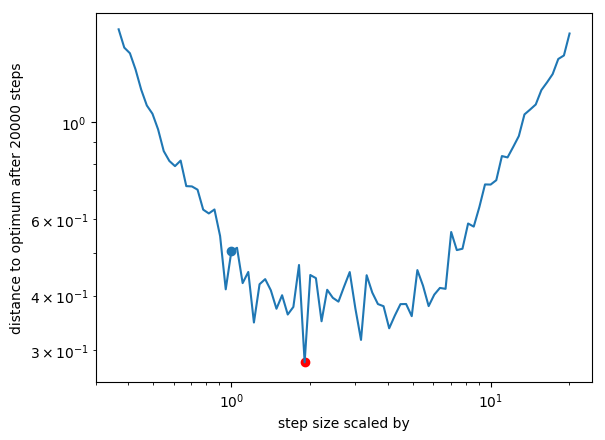

In [14]:
loglog(etas, dists);
scatter(etas[21], dists[21]);
imin = indmin(dists);
scatter(etas[imin], dists[imin]; color="red");
xlabel("step size scaled by");
ylabel("distance to optimum after 20000 steps");

Takeaway: the theory gave us something good, but not the best.

What about other algorithms? Maybe if we ran SVRG, the theoretically optimal parameters would be correct.

In [15]:
function svrg(w0, alpha, X, Y, sigma, niters, nepochs, wopt)
    w = w0
    (N, d) = size(X)
    dist_to_optimum = zeros(niters * nepochs)
    for epi = 1:nepochs
        wtilde = w;
        gtilde = X' * (Y ./ (1 + exp(Y .* (X * wtilde)))) / N - sigma * wtilde;
        for k = 1:niters
            i = rand(1:N)
            xi = X[i,:];
            yi = Y[i];
            w = w + alpha * (xi * yi / (1 + exp(yi * dot(xi, w))) - sigma * w - xi * yi / (1 + exp(yi * dot(xi, wtilde))) + sigma * wtilde + gtilde);
            dist_to_optimum[k + (epi-1)*niters] = norm(w - wopt);
        end
    end
    return (w, dist_to_optimum);
end

svrg (generic function with 1 method)

Optimal step size from our analysis was
$$\alpha = \frac{\mu}{5 L^2 e}$$
and optimal epoch length was
$$T = \frac{5 L^2 e}{\mu^2}$$.

In [16]:
alpha = mu / (5 * L^2 * e);
T = Int64(ceil(5 * L^2 * e / (mu^2)));
K = 10;

In [17]:
time1 = @timed (w, dto_svrg) = svrg(w0, alpha, X, Y, sigma, T, K, wopt);

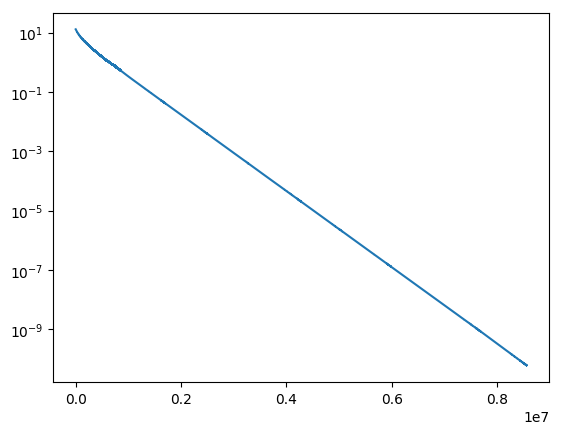

In [18]:
semilogy(dto_svrg);

In [19]:
time2 = @timed (w2, dto_svrg2) = svrg(w0, 3*alpha, X, Y, sigma, Int64(ceil(T)), K, wopt);

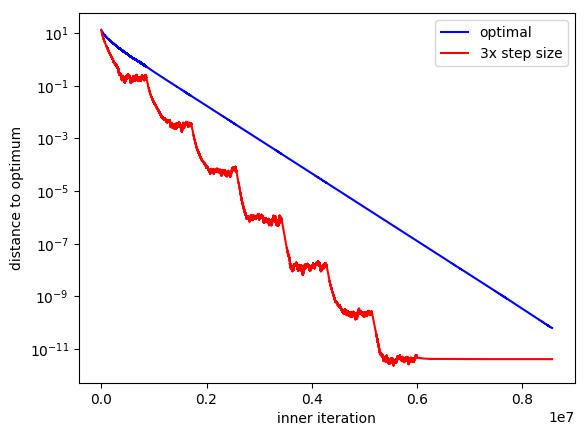

In [20]:
semilogy(dto_svrg; label = "optimal", color = "blue");
semilogy(dto_svrg2; label = "3x step size", color = "red");
xlabel("inner iteration")
ylabel("distance to optimum")
legend();

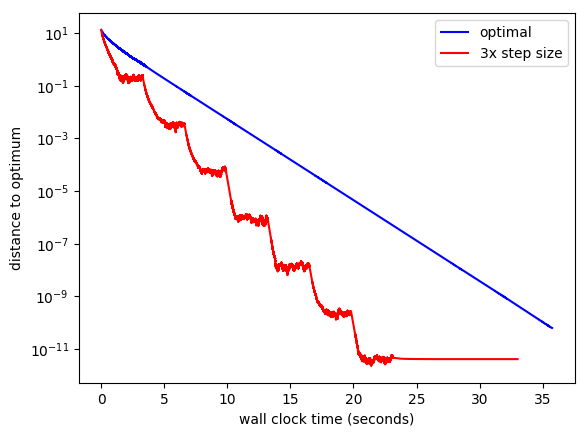

In [21]:
semilogy(collect(1:length(dto_svrg)) / length(dto_svrg) * time1[2], dto_svrg; label = "optimal", color = "blue");
semilogy(collect(1:length(dto_svrg2)) / length(dto_svrg2) * time2[2], dto_svrg2; label = "3x step size", color = "red");
xlabel("wall clock time (seconds)")
ylabel("distance to optimum")
legend();

In [22]:
srand(123456);
time3 = @timed (w3, dto_svrg3) = svrg(w0, 3.0 * alpha, X, Y, sigma, Int64(ceil(T / 2)), K, wopt);

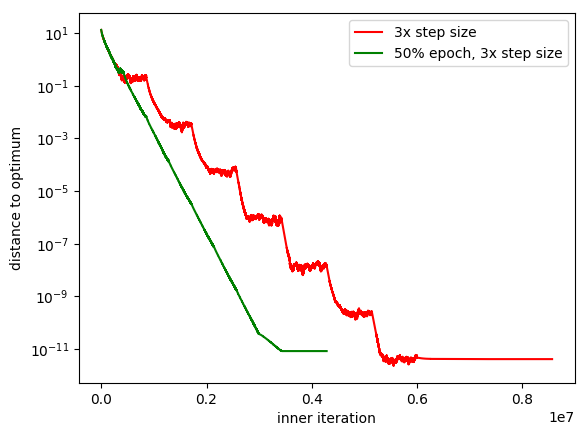

In [23]:
semilogy(dto_svrg2; label = "3x step size", color = "red");
semilogy(dto_svrg3; label = "50% epoch, 3x step size", color = "green");
xlabel("inner iteration")
ylabel("distance to optimum")
legend();

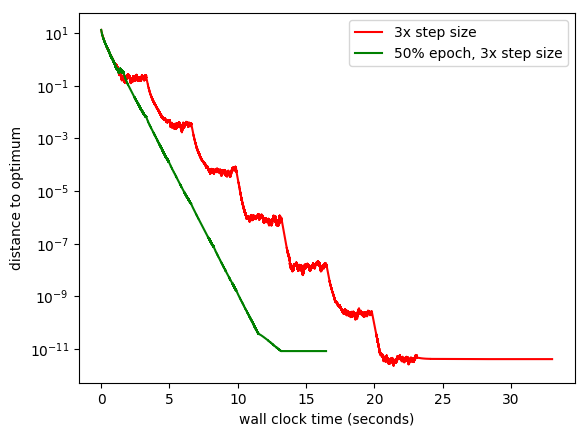

In [24]:
semilogy(collect(1:length(dto_svrg2)) / length(dto_svrg2) * time2[2], dto_svrg2; label = "3x step size", color = "red");
semilogy(collect(1:length(dto_svrg3)) / length(dto_svrg3) * time3[2], dto_svrg3; label = "50% epoch, 3x step size", color = "green");
xlabel("wall clock time (seconds)")
ylabel("distance to optimum")
legend();

## Take-away: we can often do better than the simple theoretical recipe!

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

# Can you do better?

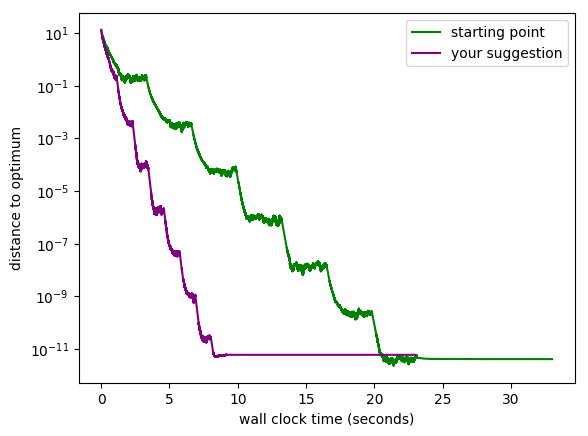

In [26]:
alpha_class = 5.0 * alpha;
T_class = Int64(ceil(T / 3));
K_class = Int64(ceil(2.0 * K));

srand(123456);
time_class = @timed (w_class, dto_svrg_class) = svrg(w0, alpha_class, X, Y, sigma, T_class, K_class, wopt);

semilogy(collect(1:length(dto_svrg2)) / length(dto_svrg2) * time2[2], dto_svrg2; label = "starting point", color = "green");
semilogy(collect(1:length(dto_svrg_class)) / length(dto_svrg_class) * time_class[2], dto_svrg_class; label = "your suggestion", color = "purple");
xlabel("wall clock time (seconds)")
ylabel("distance to optimum")
legend();